SSP1-1.9
SSP1-2.6
SSP2-4.5
SSP3-7.0
SSP5-8.5


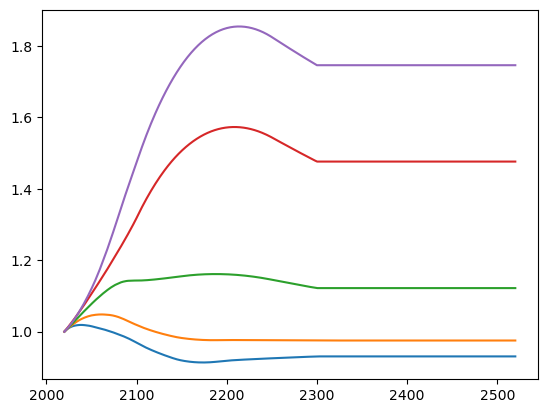

In [1]:
"""
Created on 29/08/2024, adapted from original code from 02/05/2022

@author: ADanneaux

The goal of this file is to produce carbonation coefficient trajectories based on atmospheric CO2 concentrations pathways
"""

#%% Import libraries

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import os


#%% Basic data

t = np.array(range(2000,2300))
b = 134.4
TK = 273.15           #[K]
PreIndustrial = 13.42 #[C]
PreIndustrial2 = 12.2 #[C]
P = 101.325           #[Pa]
MCO2 = 44.01          #[g/mol]
R = 82.06

raw_data_path = os.path.join("..","..","raw_data")
output_path = os.path.join("..","..","generated_data")

#%% Import concentration pathways
# Pathways are SSP concentration pathways extended to 2500 by Meinshausen, Malte, Zebedee R. J. Nicholls, Jared Lewis, Matthew J. Gidden, Elisabeth Vogel, Mandy Freund, Urs Beyerle, et al. ‘The Shared Socio-Economic Pathway (SSP) Greenhouse Gas Concentrations and Their Extensions to 2500’. Geoscientific Model Development 13, no. 8 (13 August 2020): 3571–3605. https://doi.org/10.5194/gmd-13-3571-2020.

Sheets = {"T2 - History Year 1750 to 2014":"History",
          "T3 - SSP1-1.9 ":"SSP1-1.9",
          "T4 -  SSP1-2.6 ":'SSP1-2.6',
          "T5 - SSP2-4.5 ":'SSP2-4.5',
          "T6 - SSP3-7.0 ":'SSP3-7.0',
          "T7 - SSP3-7.0-lowNTCF ":'SSP3-7.0-lowNTCF',
          "T8 - SSP4-3.4 ":"SSP4-3.4",
          "T9 - SSP4-6.0 ":"SSP4-6.0",
          "T10 - SSP5-3.4-over ":"SSP5-3.4-over",
          "T11 - SSP5-8.5 ":"SSP5-8.5"}


CO2_concentrations = pd.DataFrame(columns=['Years'])

for sheet,scenario in Sheets.items():
    Data = pd.read_excel(os.path.join(raw_data_path,"SUPPLEMENT_DataTables_Meinshausen_6May2020.xlsx"),
                        sheet_name=sheet,
                        skiprows=8,
                        header=[0,1,2,3])

    years = Data.loc[:, ('Gas','Unit','Region','Year')].values
    concentration = Data.loc[:, ('CO2','ppm','World',slice(None))].values.transpose()[0]

    filtered_data = pd.DataFrame({'Years':years,scenario:concentration})

    CO2_concentrations = pd.merge(CO2_concentrations,filtered_data,on='Years',how='outer')

CO2_concentrations.set_index('Years',inplace=True)
for scenario in CO2_concentrations.columns:
    CO2_concentrations.loc[1750:2014,scenario] = CO2_concentrations.loc[1750:2014,'History']

#%%  Temperature needed
temperature_data_path = os.path.join(raw_data_path,"AR6_WGI_SPM8a")
# 2300 Temperature from Meinshausen, Malte, Zebedee R. J. Nicholls, Jared Lewis, Matthew J. Gidden, Elisabeth Vogel, Mandy Freund, Urs Beyerle, et al. ‘The Shared Socio-Economic Pathway (SSP) Greenhouse Gas Concentrations and Their Extensions to 2500’. Geoscientific Model Development 13, no. 8 (13 August 2020): 3571–3605. https://doi.org/10.5194/gmd-13-3571-2020.
T2300 = {
    "SSP1-1.9":0.6,
    "SSP1-2.6":1.3,
    "SSP2-4.5":3.8,
    "SSP3-7.0":9.8,
    # "SSP4-3.4":1.8,
    # "SSP4-6.0":6,
    "SSP5-8.5":10.8
}

Temperature = pd.DataFrame(columns=['Years'])

for scenario, t2300 in T2300.items():
    T = pd.read_csv(os.path.join(temperature_data_path,"tas_global_"+scenario.replace('-','_').replace('.','_')+".csv"))

    temp = T['Mean'].values
    years = T['Year'].values

    filtered_data = pd.DataFrame({'Years':years,scenario:temp})
    Temperature = pd.merge(Temperature,filtered_data,on='Years',how='outer')

Temperature.set_index('Years',inplace=True)

for scenario,  t2300 in T2300.items():
    Temperature.loc[2300,scenario]=t2300

all_years = pd.Index(range(2015,2301), name="Years")
Temperature = Temperature.reindex(all_years)
Temperature = Temperature.interpolate(method='linear')
Temperature = Temperature+PreIndustrial2
#%% Calculating X concentrations

X =P*MCO2/R * CO2_concentrations.reindex(index= all_years, columns=Temperature.columns).divide(Temperature)

#%% Calulating variations in K

K = np.sqrt(X/X.iloc[5,:])

# Interpolating
SOL = 2020
TOD = 500           #[years]
n = TOD*200+1
t_TOD = np.linspace(SOL+0,SOL+TOD,n) 
dt = t_TOD[1]-t_TOD[0]


# Assumes no change in carbonation rate post 2300
K=K.reindex(t_TOD)
K=K.interpolate(method='linear')

#%%

for scenario in K.columns:
    print(scenario)
    file_name = 'K'+scenario.replace("SSP",'').replace("-",'').replace(".",'')+'.csv'
    K.loc[:,scenario].to_csv(os.path.join(output_path,file_name),index=False,header=False)

#%%
fig, ax = plt.subplots()
for scenario in K.columns:
    ax.plot(K.index,K.loc[:,scenario])